In [ ]:
from typing import Generic, Optional, Tuple, List, Callable, Iterable, Mapping

import numpy as np
import pandas as pd
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import utils
from utils import debugt, debugs, debug
import datetime

import fishdetr_batchboy as detr
from generators import TorchStereoDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('./detr_custom/')
from models.matcher import HungarianMatcher
from models.detr import SetCriterion
import os
import sqlite3

In [ ]:
seed = 42069
utils.seed_everything(seed)

try:
    device = utils.pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
    print(utils.get_cuda_status(device))
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

In [ ]:
TORCH_CACHE_DIR = 'torch_cache'
DATASET_DIR = '/mnt/blendervol/objdet_std_data'
DATASET_DIR = '/mnt/blendervol/leftright_left_data'
TABLE = 'bboxes_std'
WEIGHTS_DIR = 'fish_statedicts'
torch.hub.set_dir(TORCH_CACHE_DIR)
num2name = eval(open(os.path.join(DATASET_DIR,"metadata.txt"), 'r').read())

In [ ]:
def _validate_model(context: dict, traintqdminfo: dict) -> dict:
    model = context['model']
    criterion = context['criterion']

    running_val_loss = 0.0
    # valbar will disappear after it is done since leave=False
    valbar = tqdm(
        iterable=enumerate(context['valloader'], 0), 
        total=len(context['valloader']), 
        unit=' batches',
        desc=f' Validating',
        ascii=True,
        position=0,
        leave=False
    )

    model.eval()
    criterion.eval()

    # Loop through val batches
    with torch.no_grad():
        for i, (images, labels) in valbar:
            X, y = detr.preprocess(images, labels, context['device'])

            output: detr.DETROutput
            loss: torch.Tensor
            output, loss = model.eval_on_batch(X, y, criterion)
            
            # print statistics
            running_val_loss += loss.item()
            val_loss = running_val_loss / (i+1)
            valtqdminfo = {**traintqdminfo, 'val loss':val_loss}
            valbar.set_postfix(valtqdminfo)
            
    return valtqdminfo


def _train_model(context: dict, epoch: int, n_epochs: int, leave_tqdm: bool) -> Tuple[Iterable, dict]:
    model = context['model']
    criterion = context['criterion']
    
    running_train_loss = 0.0
    trainbar = tqdm(
        iterable=enumerate(context['trainloader'], 0),
        total=len(context['trainloader']),
        unit=' batches',
        desc=f' Epoch {epoch+1}/{n_epochs}',
        ascii=True,
        position=0,
        leave=leave_tqdm
    )

    model.train()
    criterion.train()

    # Loop through train batches
    for i, (images, labels) in trainbar:
        X, y = detr.preprocess(images, labels, context['device'])

        output: detr.DETROutput
        loss: torch.Tensor
        output, loss = model.train_on_batch(X, y, criterion, optimizer)

        # print statistics
        running_train_loss += loss.item()
        train_loss = running_train_loss / (i+1)
        traintqdminfo = {'train loss':train_loss}
        trainbar.set_postfix(traintqdminfo)
    
    return trainbar, traintqdminfo


@utils.interruptable
def train_model(
        trainloader: DataLoader, 
        valloader: DataLoader, 
        model: nn.Module, 
        criterion, 
        optimizer, 
        n_epochs: int, 
        device: torch.device, 
        validate: bool = True,
        save_best: bool = True
    ):
    
    # for convenience
    context = {
        'trainloader':trainloader,
        'valloader':valloader,
        'model':model,
        'criterion':criterion,
        'optimizer':optimizer,
        'device':device
    }
    
    best_val_loss = np.inf
    
    for epoch in range(n_epochs):
        trainbar, traintqdminfo = _train_model(context, epoch, n_epochs, not validate)
            
        if validate:
            valtqdminfo = _validate_model(context, traintqdminfo)
        
            # Extra dirty tqdm hack hehe
            # _validate_model will create its own tqdm bar that will replace the bar
            # from _train_model, but will clear itself afterwards
            # the code below reactivates the previous train bar
            trainbar.disable = False
            trainbar.set_postfix({**traintqdminfo, **valtqdminfo})
            trainbar.disable = True
            print(file=sys.stderr) # for newline
        
            # Save best models
            if save_best:
                if valtqdminfo['val loss'] < best_val_loss:
                    best_val_loss = valtqdminfo['val loss']
                    isodatenow = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
                    daydir = datetime.today().strftime("weights_%Y-%m-%d")
                    filename = (
                        f'detr_statedicts_epoch{epoch+1}'
                        f'_train{traintqdminfo["train loss"]:.4f}_val{best_val_loss:.4f}'
                        f'_{isodatenow}.pth'
                    )
                    filepath = os.path.join(WEIGHTS_DIR, daydir, filename)

                    save_model(
                        obj={
                            'model_state_dict':model.state_dict(),
                            'optimizer':optimizer.state_dict(),
                            'criterion':criterion.state_dict(),
                        },
                        f = filepath
                    )

In [11]:
model = detr.FishDETR(freeze_encoder=False).to(device)

Encoder successfully loaded with pretrained weights


In [12]:
db_con = sqlite3.connect(f'file:{os.path.join(DATASET_DIR,"bboxes.db")}?mode=ro', uri=True)
n_data = pd.read_sql_query('SELECT COUNT(DISTINCT(imgnr)) FROM bboxes_std', db_con).values[0][0]

TRAIN_RANGE = (0, int(3/4*n_data))
VAL_RANGE = (int(3/4*n_data), n_data)

TRAIN_RANGE = (0, 12)
VAL_RANGE = (32, 48)

In [13]:
traingen = TorchStereoDataset(DATASET_DIR, TABLE, 1, shuffle=True, imgnrs=range(*TRAIN_RANGE))
valgen = TorchStereoDataset(DATASET_DIR, TABLE, 1, shuffle=False, imgnrs=range(*VAL_RANGE))

BATCH_SIZE = 6
trainloader = DataLoader(
    dataset = traingen,
    batch_size = BATCH_SIZE,
    collate_fn = detr.collate,
)

valloader = DataLoader(
    dataset = valgen,
    batch_size = BATCH_SIZE,
    collate_fn = detr.collate,
)

In [14]:
weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']
matcher = HungarianMatcher()
criterion = SetCriterion(6, matcher, weight_dict, eos_coef = 0.5, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-7)

In [19]:
optimizer.param_groups[0]['lr'] = 1e-7

train_model(
    trainloader,
    valloader,
    model,
    criterion,
    optimizer,
    n_epochs=1000,
    device=device,
    save_best=False,
    validate=False
)

 Epoch 63/1000:  50%|#####     | 1/2 [00:00<00:00,  3.19 batches/s, train loss=0.295]

Process interrupted


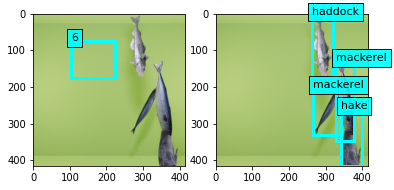

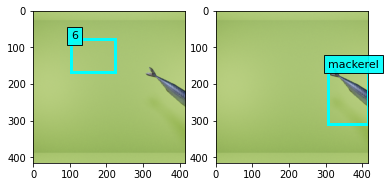

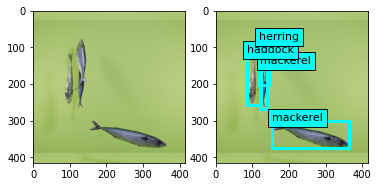

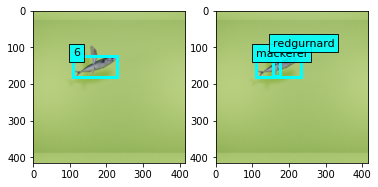

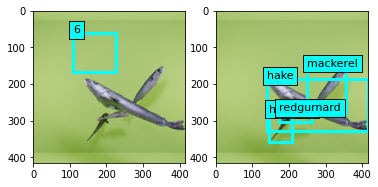

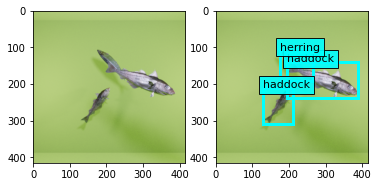

In [22]:
X, y = next(iter(trainloader))
X, y = detr.preprocess(X, y, device)
model.forward_and_plot(X, y, classmap=num2name, thresh=0.05)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [ ]:
raise ValueError